In [ ]:
pip install numpy nibabel monai torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

# Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob

# 1. Define the path based on your screenshot
data_dir = '/content/drive/MyDrive/Colab Notebooks/Healing_Algorithms_Training_Data'

train_files = []

# Check if the computer can see the folder
if not os.path.exists(data_dir):
    print(f"ERROR: Cannot find folder at {data_dir}")
    print("Please check if 'Healing_Algorithms_Training_Data' is definitely inside 'Colab Notebooks'.")
else:
    print(f"Folder found!")

    # 2. Get all patient folders
    patient_folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

    for patient in patient_folders:
        patient_path = os.path.join(data_dir, patient)

        # 3. Define paths for the 4 MRI types + 1 Label
        t1 = os.path.join(patient_path, f"{patient}_t1.nii.gz")
        t1ce = os.path.join(patient_path, f"{patient}_t1ce.nii.gz")
        t2 = os.path.join(patient_path, f"{patient}_t2.nii.gz")
        flair = os.path.join(patient_path, f"{patient}_flair.nii.gz")
        seg = os.path.join(patient_path, f"{patient}_seg.nii.gz")

        # 4. Add to list only if files exist
        if os.path.exists(t1) and os.path.exists(seg):
            train_files.append(
                {
                    "image": [t1, t1ce, t2, flair], # Input: 4 channels
                    "label": seg                    # Output: Mask
                }
            )

    print(f"Successfully found {len(train_files)} patients.")

Folder found!
Successfully found 0 patients.


In [ ]:
import os

# 1. Use the path that we know works
data_dir = '/content/drive/MyDrive/Colab Notebooks/Healing_Algorithms_Training_Data'

print(f"Checking contents of: {data_dir}")

# 2. Get the list of patient folders again
patient_folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

if len(patient_folders) > 0:
    first_patient = patient_folders[0]
    print(f"\n--- Found Patient Folder: {first_patient} ---")

    # 3. List everything inside this first patient's folder
    first_patient_path = os.path.join(data_dir, first_patient)
    files_inside = os.listdir(first_patient_path)

    print("Files inside this folder:")
    for f in files_inside:
        print(f" - {f}")
else:
    print("\nERROR: No patient folders found inside the data directory.")
    print("Is the folder empty?")

Checking contents of: /content/drive/MyDrive/Colab Notebooks/Healing_Algorithms_Training_Data

--- Found Patient Folder: HelioGLI-00000-000 ---
Files inside this folder:
 - Helio-GLI-00000-000-t1c.nii.gz
 - Helio-GLI-00000-000-t2w.nii.gz
 - Helio-GLI-00000-000-seg.nii.gz
 - Helio-GLI-00000-000-t2f.nii.gz
 - Helio-GLI-00000-000-t1n.nii.gz
 - HelioGLI-00000-000


In [ ]:
import os
import glob

data_dir = '/content/drive/MyDrive/Colab Notebooks/Healing_Algorithms_Training_Data'
train_files = []

if not os.path.exists(data_dir):
    print("Error: Main folder still not found.")
else:
    # Get all patient folders
    patient_folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

    for patient in patient_folders:
        patient_path = os.path.join(data_dir, patient)

        # FIX 1: The filename has a hyphen "Helio-GLI" but folder is "HelioGLI"
        # We replace "HelioGLI" with "Helio-GLI" for the filename prefix
        file_prefix = patient.replace("HelioGLI", "Helio-GLI")

        # FIX 2: Use the exact suffixes from your debug output
        # T1 Native -> t1n
        # T1 Contrast -> t1c
        # T2 Weighted -> t2w
        # T2 FLAIR -> t2f
        t1n = os.path.join(patient_path, f"{file_prefix}-t1n.nii.gz")
        t1c = os.path.join(patient_path, f"{file_prefix}-t1c.nii.gz")
        t2w = os.path.join(patient_path, f"{file_prefix}-t2w.nii.gz")
        t2f = os.path.join(patient_path, f"{file_prefix}-t2f.nii.gz")
        seg = os.path.join(patient_path, f"{file_prefix}-seg.nii.gz")

        # Check if files exist
        if os.path.exists(t1n) and os.path.exists(seg):
            train_files.append(
                {
                    "image": [t1n, t1c, t2w, t2f], # Input: 4 channels
                    "label": seg                   # Output: Mask
                }
            )
        else:
            # logic to debug if a specific patient fails
            pass

    print(f"Successfully found {len(train_files)} patients.")
    if len(train_files) > 0:
        print("Sample loaded successfully.")

Successfully found 236 patients.
Sample loaded successfully.


In [ ]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    Spacingd, NormalizeIntensityd, CropForegroundd, RandCropByPosNegLabeld
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"], label_key="label",
            spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4,
            image_key="image", image_threshold=0,
        ),
    ]
)
print("Transforms ready.")

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Transforms ready.


/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

# 1. Set a random seed so results are reproducible
set_determinism(seed=0)

# 2. Create the Dataset
# We use standard 'Dataset' instead of 'CacheDataset' to save RAM on Colab
train_ds = Dataset(data=train_files, transform=train_transforms)

# 3. Create the Data Loader
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=2
)

print("Data Loader ready.")
# Check the shape of one batch to ensure it works
check_data = next(iter(train_loader))
print(f"Input Shape: {check_data['image'].shape}")
print(f"Label Shape: {check_data['label'].shape}")
# Expected Input Shape: (1, 4, 96, 96, 96) -> (Batch, Channels, H, W, D)

Data Loader ready.
Input Shape: torch.Size([4, 4, 96, 96, 96])
Label Shape: torch.Size([4, 1, 96, 96, 96])


In [ ]:
import torch
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from torch.optim import Adam

# 1. Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# 2. Define the Model
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,   # Keep this low (16) to fit in Colab memory
    in_channels=4,     # 4 MRI Modalities
    out_channels=3,    # 3 Tumor Classes (Labels 1, 2, 4)
    dropout_prob=0.2,
).to(device)

# 3. Define Loss Function (Dice Loss is standard for segmentation)
# sigmoid=True because we treat each tumor class as a separate "Yes/No" problem
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# 4. Optimizer
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

print("Model, Loss, and Optimizer initialized.")

Training on device: cuda
Model, Loss, and Optimizer initialized.


In [ ]:
import torch
import time

# 1. Setup
max_epochs = 5  # We start with 5 epochs to make sure it works.
print(f"Starting training on {device} for {max_epochs} epochs...")

for epoch in range(max_epochs):
    print(f"-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    start_time = time.time()

    for batch_data in train_loader:
        step += 1

        # 1. Get Data and move to GPU
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # 2. Zero the Gradients
        optimizer.zero_grad()

        # 3. Forward Pass (Make Prediction)
        outputs = model(inputs)

        # 4. PREPARE TARGETS (Crucial: Split labels 1, 2, 4 into 3 separate channels)
        # Channel 0: Edema (Label 1)
        # Channel 1: Enhancing Tumor (Label 2)
        # Channel 2: Necrotic Tumor (Label 4)
        target_c1 = (labels == 1).float()
        target_c2 = (labels == 2).float()
        target_c3 = (labels == 4).float()

        # Stack them -> Shape (Batch, 3, 96, 96, 96)
        targets = torch.cat([target_c1, target_c2, target_c3], dim=1)

        # 5. Calculate Loss
        loss = loss_function(outputs, targets)

        # 6. Backward Pass (Learn)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Print progress every 10 steps
        if step % 10 == 0:
            print(f"{step}/{len(train_ds)} - train_loss: {loss.item():.4f}")

    # End of Epoch Summary
    epoch_loss /= step
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    print(f"Time taken: {time.time() - start_time:.0f} seconds")

    # Save the model weights
    torch.save(model.state_dict(), "model_current.pth")

print("Training completed! Model saved as 'model_current.pth'")

Starting training on cuda for 5 epochs...
----------
Epoch 1/5
10/236 - train_loss: 0.9795
20/236 - train_loss: 0.8801
30/236 - train_loss: 0.9601
40/236 - train_loss: 0.8468
50/236 - train_loss: 0.9783
60/236 - train_loss: 0.8792
70/236 - train_loss: 0.8806
80/236 - train_loss: 0.9655
90/236 - train_loss: 0.8882
100/236 - train_loss: 0.8596
110/236 - train_loss: 0.9731
120/236 - train_loss: 0.8594
130/236 - train_loss: 0.9788
140/236 - train_loss: 0.9258
150/236 - train_loss: 0.9098
160/236 - train_loss: 0.8780
170/236 - train_loss: 0.8281
180/236 - train_loss: 0.8233
190/236 - train_loss: 0.8577
200/236 - train_loss: 0.8579
210/236 - train_loss: 0.7813
220/236 - train_loss: 0.8920
230/236 - train_loss: 0.8282
Epoch 1 average loss: 0.8888
Time taken: 575 seconds
----------
Epoch 2/5
10/236 - train_loss: 0.9509
20/236 - train_loss: 0.9566
30/236 - train_loss: 0.9149
40/236 - train_loss: 0.9075
50/236 - train_loss: 0.9680
60/236 - train_loss: 0.9490
70/236 - train_loss: 0.9436
80/236 - 

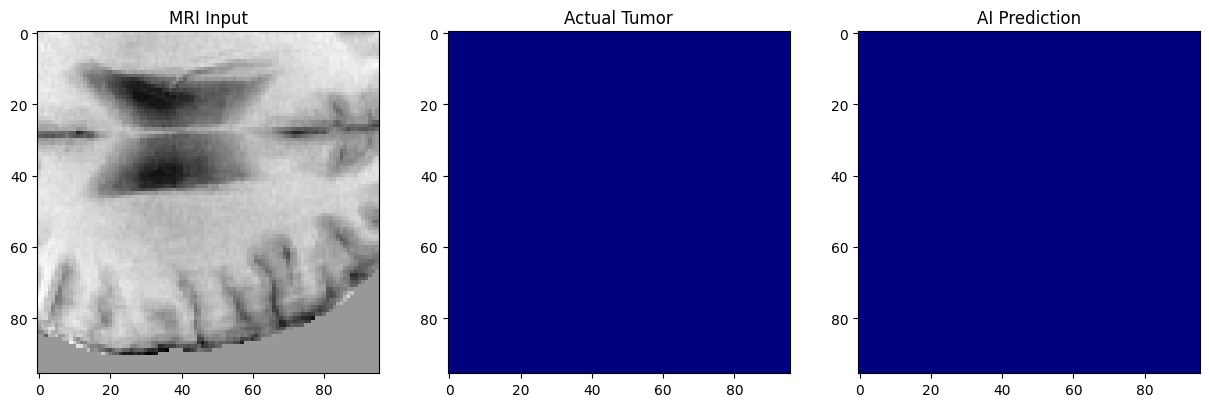

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    # 1. Get the list of crops for the first patient
    patient_crops = train_ds[0]

    # FIX: Pick the first crop from the list of 4
    check_data = patient_crops[0]

    # 2. Prepare input
    image = check_data["image"].unsqueeze(0).to(device)
    label = check_data["label"]

    # 3. Run Inference
    output = model(image)

    # 4. Convert to binary mask (0 or 1)
    prediction = (output > 0.5).float()

    # 5. VISUALIZATION
    # Slice 48 is usually the middle of a 96x96x96 crop
    slice_idx = 48

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Show MRI (Channel 0 - T1n)
    ax1.imshow(image[0, 0, :, :, slice_idx].cpu(), cmap="gray")
    ax1.set_title("MRI Input")

    # Show Ground Truth (Channel 0 of label)
    # Note: Label might be (1, 96, 96, 96) or just (96, 96, 96) depending on loader
    # We grab the first channel if it exists
    if len(label.shape) == 4:
        display_label = label[0, :, :, slice_idx]
    else:
        display_label = label[:, :, slice_idx]

    ax2.imshow(display_label, cmap="jet")
    ax2.set_title("Actual Tumor")

    # Show Prediction (Channel 1 - Enhancing Tumor)
    ax3.imshow(prediction[0, 1, :, :, slice_idx].cpu(), cmap="jet")
    ax3.set_title("AI Prediction")

    plt.show()

Hunting for a tumor... this might take a second...


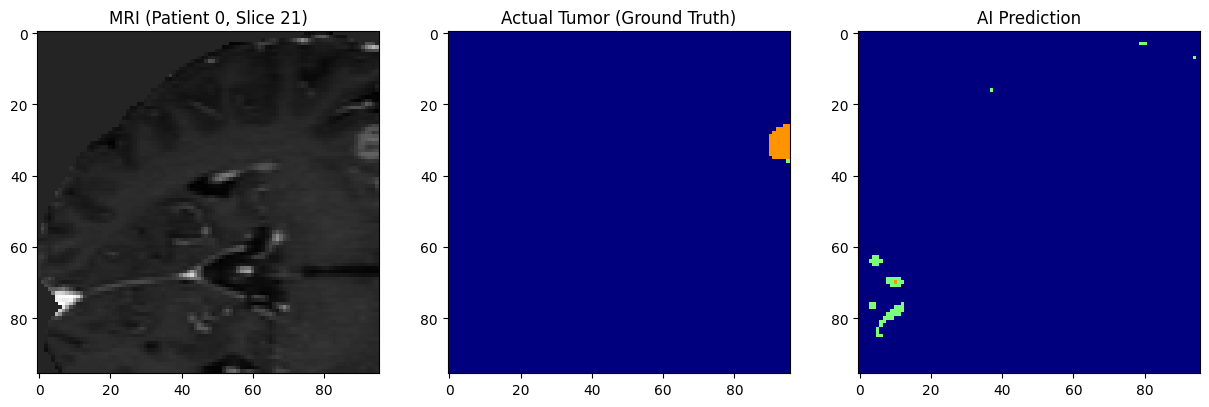

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Hunting for a tumor... this might take a second...")

with torch.no_grad():
    found_tumor = False

    # Loop through the first 5 patients
    for i in range(5):
        if found_tumor: break

        # Get the list of crops for patient 'i'
        patient_crops = train_ds[i]

        for crop in patient_crops:
            # FIX: Get the label (Shape is [1, 96, 96, 96])
            label = crop["label"]

            # Check if there is ANY tumor in this crop (values > 0)
            if label.sum() > 0:
                image = crop["image"].unsqueeze(0).to(device)

                # Predict
                output = model(image)
                prediction = (output > 0.5).float()

                # FIX: Find slice with most tumor pixels using channel 0
                # We look at the 'deepest' part of the tumor
                slice_idx = torch.argmax((label[0] > 0).sum(dim=(0, 1))).item()

                # --- PLOTTING ---
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

                # 1. MRI Input (Showing T1-Contrast Channel 1)
                ax1.imshow(image[0, 1, :, :, slice_idx].cpu(), cmap="gray")
                ax1.set_title(f"MRI (Patient {i}, Slice {slice_idx})")

                # 2. Actual Tumor (Ground Truth)
                # It already contains 0, 1, 2, 4, so we just show it directly
                ax2.imshow(label[0, :, :, slice_idx], cmap="jet", vmin=0, vmax=4)
                ax2.set_title("Actual Tumor (Ground Truth)")

                # 3. AI Prediction
                # We combine the 3 output channels back into one map to look like the Ground Truth
                # Channel 0 (Edema) -> Val 1
                # Channel 1 (Core) -> Val 2
                # Channel 2 (Necrosis) -> Val 4
                pred_map = (prediction[0, 0] * 1) + (prediction[0, 1] * 2) + (prediction[0, 2] * 4)

                ax3.imshow(pred_map[:, :, slice_idx].cpu(), cmap="jet", vmin=0, vmax=4)
                ax3.set_title("AI Prediction")

                plt.show()

                found_tumor = True
                break

if not found_tumor:
    print("Could not find a tumor in these crops. Try running it again (random crops might miss).")

In [ ]:
import os

# 1. Define the path (Matches your screenshot name exactly)
# Make sure you added the shortcut to 'Colab Notebooks' just like before!
val_dir = '/content/drive/MyDrive/Colab Notebooks/Healing_ALgorithms_Val_Data'

if not os.path.exists(val_dir):
    print(f"Error: Could not find folder at {val_dir}")
    print("Did you right-click the folder and 'Add Shortcut' to your Drive > Colab Notebooks?")
else:
    print("Found Validation Data!")

    # 2. Look inside the first patient folder
    patients = os.listdir(val_dir)
    if len(patients) > 0:
        first_patient = patients[0]
        files = os.listdir(os.path.join(val_dir, first_patient))

        print(f"\nChecking Patient: {first_patient}")
        print("Files found:")
        for f in files:
            print(f" - {f}")

        # 3. The Critical Check
        if any("seg" in f for f in files):
            print("\nSTATUS: This data HAS labels (Answers). You can test your accuracy here!")
        else:
            print("\nSTATUS: This data has NO labels. You must run your model to generate predictions.")

Found Validation Data!

Checking Patient: HelioGLI-00510-000
Files found:
 - Helio-GLI-00510-000-t2w.nii.gz
 - Helio-GLI-00510-000-t2f.nii.gz
 - Helio-GLI-00510-000-seg.nii.gz
 - Helio-GLI-00510-000-t1n.nii.gz
 - Helio-GLI-00510-000-t1c.nii.gz
 - HelioGLI-00510-000

STATUS: This data HAS labels (Answers). You can test your accuracy here!


In [ ]:
import os
import glob

# 1. Define the Validation Path (Matches your screenshot)
val_dir = '/content/drive/MyDrive/Colab Notebooks/Healing_ALgorithms_Val_Data'
val_files = []

# 2. Get all patient folders
patient_folders = sorted([f for f in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, f))])

print(f"Preparing validation list for {len(patient_folders)} patients...")

for patient in patient_folders:
    patient_path = os.path.join(val_dir, patient)

    # Handle the Hyphen mismatch (Folder "HelioGLI" -> File "Helio-GLI")
    file_prefix = patient.replace("HelioGLI", "Helio-GLI")

    t1n = os.path.join(patient_path, f"{file_prefix}-t1n.nii.gz")
    t1c = os.path.join(patient_path, f"{file_prefix}-t1c.nii.gz")
    t2w = os.path.join(patient_path, f"{file_prefix}-t2w.nii.gz")
    t2f = os.path.join(patient_path, f"{file_prefix}-t2f.nii.gz")
    seg = os.path.join(patient_path, f"{file_prefix}-seg.nii.gz")

    if os.path.exists(t1n) and os.path.exists(seg):
        val_files.append(
            {
                "image": [t1n, t1c, t2w, t2f],
                "label": seg
            }
        )

print(f"Validation list ready with {len(val_files)} items.")

Preparing validation list for 66 patients...
Validation list ready with 66 items.


In [ ]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, NormalizeIntensityd, CropForegroundd
from monai.data import DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
import torch

# 1. Define Validation Transforms (Full brain, no random cropping)
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
])

# 2. Create Loader
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

# 3. Setup Metrics
dice_metric = DiceMetric(include_background=False, reduction="mean")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Starting Validation on {len(val_ds)} patients...")

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_inputs = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)

        # Run Inference (Sliding Window scans the brain in chunks)
        val_outputs = sliding_window_inference(
            inputs=val_inputs,
            roi_size=(96, 96, 96),
            sw_batch_size=4,
            predictor=model
        )

        # Convert prediction to binary (0 or 1)
        val_outputs = (val_outputs > 0.5).float()

        # Prepare targets (Split label 1, 2, 4 into 3 channels to match output)
        t_c1 = (val_labels == 1).float()
        t_c2 = (val_labels == 2).float()
        t_c3 = (val_labels == 4).float()
        val_targets = torch.cat([t_c1, t_c2, t_c3], dim=1)

        # Calculate Score
        dice_metric(y_pred=val_outputs, y=val_targets)

        # Print progress every 10 patients
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(val_ds)} patients...")

    # 4. Final Score
    mean_dice = dice_metric.aggregate().item()
    dice_metric.reset()

print("-" * 30)
print(f"FINAL DICE SCORE: {mean_dice:.4f}")
print("-" * 30)

Starting Validation on 66 patients...


/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  out

Processed 10/66 patients...
Processed 20/66 patients...
Processed 30/66 patients...
Processed 40/66 patients...
Processed 50/66 patients...
Processed 60/66 patients...
------------------------------
FINAL DICE SCORE: 0.7120
------------------------------
